El acoso escolar, o *bullying*, constituye uno de los desafíos más relevantes en el ámbito educativo contemporáneo. Este fenómeno se caracteriza por conductas repetidas de intimidación, humillación o agresión, ejercidas intencionadamente hacia un estudiante que percibe dificultad para defenderse. Sus consecuencias abarcan desde el deterioro del bienestar emocional, la ansiedad o la depresión, hasta el aislamiento social, bajo rendimiento académico e incluso riesgo de abandono escolar.

A nivel europeo, el problema tiene una magnitud considerable. De acuerdo con datos recientes de la Oficina Regional de la Organización Mundial de la Salud (OMS Europa), aproximadamente **11 % de los adolescentes han sido víctimas de acoso** tradicional en la escuela y cerca del 15 % han experimentado ciberacoso. Estas cifras reflejan un incremento asociado al uso intensivo de dispositivos digitales y redes sociales, especialmente desde la pandemia.

En el contexto español, los datos indican una situación igualmente preocupante. Informes educativos nacionales reflejan que alrededor del 24 % de los estudiantes identifica episodios de acoso en su centro escolar durante el último curso académico. Estudios sistemáticos sitúan la prevalencia real en torno al 11,45 %, con mayor incidencia en formas verbales, relacionales y psicológicas, que suelen resultar menos visibles que las agresiones físicas. Además, las víctimas de acoso presentan mayores niveles de ansiedad, estrés, deterioro socioemocional y menor participación escolar.

Estas cifras ponen de manifiesto que el bullying no es un hecho aislado, sino un problema estructural que requiere una actuación coordinada por parte de los centros educativos, familias, profesionales de la salud y administraciones públicas. La prevención y la intervención eficaz dependen de identificar tempranamente las señales, promover una cultura de convivencia positiva y diseñar programas basados en la evidencia.

El presente informe analiza la situación del acoso escolar  a partir de datos actuales, examina los factores asociados, evalúa su impacto emocional y educativo, y propone líneas de actuación que contribuyan a reducir su incidencia y favorecer entornos escolares seguros e inclusivos.

### Configuración y versiones (reproducibilidad)
- fija semilla, rutas, importa librerías y muestra versiones.

In [1]:
# ==============================================
# PROYECTO: Detección de Bullying Escolar
# ==============================================
# Configuración del entrono y versiones de librerias.
Semilla = 1234
from pathlib import Path
RUTA_FICHERO = Path('.')

# Libreriras utilizadas

import numpy as np
import sys, platform
import pandas as pd
import sklearn
import matplotlib
import seaborn as sns
import imblearn as imbl

# Versiónes
print({
    'python': sys.version.split()[0],
    'os': platform.platform(),
    'pandas': pd.__version__,
    'numpy': np.__version__,
    'scikit-learn': sklearn.__version__,
    'matplotlib': matplotlib.__version__,
    'seaborn': sns.__version__,
})

{'python': '3.13.9', 'os': 'Windows-11-10.0.26200-SP0', 'pandas': '2.3.3', 'numpy': '2.3.3', 'scikit-learn': '1.7.2', 'matplotlib': '3.10.6', 'seaborn': '0.13.2'}


In [2]:
# Preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modelos de clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Métricas de evaluación y búsqueda
from sklearn.metrics import (classification_report, confusion_matrix,
                             precision_score, recall_score, f1_score, accuracy_score, roc_auc_score)
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import RocCurveDisplay

# Utilidades graficas
import matplotlib.pyplot as plt

### Carga de datos y normalización del objetivo
- Carga `Bullying1.csv` y `Bullying2.csv`.
- Normaliza el objetivo `Sufre_Bullying` a {0,1} con mapeo robusto (sí/s/true/1, no/n/false/0).
- Evita posibles incoherencias por capitalización/acentos/idioma.

In [3]:
# ==============================================
# Carga de datos
# ==============================================
dfOld = pd.read_csv(RUTA_FICHERO / "Bullying1.csv")
df = pd.read_csv(RUTA_FICHERO / "Bullying2.csv")

# Variable objetivo
target_col = "Sufre_Bullying"

# ==============================================
# Limpieza y codificación del objetivo
# ==============================================
# Convertimos la variable objetivo a 0/1
# Con  `.astype(str).str.strip().str.lower()`: se normaliza el texto antes de mapear.
# `.map({...})`: transforma etiquetas heterogéneas → binario.
df[target_col] = df[target_col].astype(str).str.strip().str.lower().map({
    "si": 1, "sí": 1, "s": 1, "yes": 1, "true": 1, "1": 1,
    "no": 0, "n": 0, "false": 0, "0": 0
})
dfOld[target_col] = dfOld[target_col].astype(str).str.strip().str.lower().map({
    "si": 1, "sí": 1, "s": 1, "yes": 1, "true": 1, "1": 1,
    "no": 0, "n": 0, "false": 0, "0": 0
})

# ==============================================
# Separación de variables predictoras y objetivo
# ==============================================
XOld = dfOld.drop(columns=[target_col])
yOld = dfOld[target_col]

X = df.drop(columns=[target_col])
y = df[target_col]

### Análisis exploraritorio de datos (EDA)
- Muestra información sobre los datos de ambos conjuntos.

In [4]:
# ==============================================
# Identificación de tipos de variables del primer conjunto de datos
# ==============================================
cat_colsOld = XOld.select_dtypes(include=["object", "category"]).columns.tolist()
num_colsOld = XOld.select_dtypes(include=[np.number]).columns.tolist()
XOld.describe()

,Edad,Horas_Sueno,Notas_Promedio,Numero_Amigos,Tiempo_Videojuegos,Tiempo_Redes,Actividades_Extracurr,Ausencias_Escolares,Autoestima,Ansiedad,Depresion,Conflictos_Familiares,Tiempo_Internet,Actividad_Fisica
count,1900.000000,2000.000000,2000.000000,1900.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,14.478947,7.010350,4.951950,6.878421,2.921400,4.946450,2.020000,14.523500,6.456264,6.410275,4.878950,4.514500,6.022200,3.544050
std,1.718186,1.714826,2.870945,4.283337,1.720919,2.843097,1.413718,8.633059,6.854294,6.788385,2.910039,2.822193,3.467883,2.043938
min,12.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,5.500000,2.500000,3.000000,1.400000,2.500000,1.000000,7.000000,2.700000,2.700000,2.300000,2.000000,3.100000,1.800000
50%,14.000000,7.100000,4.900000,7.000000,2.900000,4.900000,2.000000,15.000000,5.300000,5.200000,4.900000,4.000000,5.900000,3.550000
75%,16.000000,8.500000,7.500000,11.000000,4.400000,7.300000,3.000000,22.000000,7.900000,7.900000,7.400000,7.000000,9.100000,5.300000
max,17.000000,10.000000,10.000000,14.000000,6.000000,10.000000,4.000000,29.000000,33.739279,33.402491,10.000000,9.000000,12.000000,7.000000


In [5]:
# ==============================================
# 5. Identificación de tipos de variables del conjunto actualizado
# ==============================================
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X.describe()

,Edad,Horas_Sueno,Notas_Promedio,Numero_Amigos,Tiempo_Videojuegos,Tiempo_Redes,Actividades_Extracurr,Ausencias_Escolares,Autoestima,Ansiedad,Depresion,Conflictos_Familiares,Tiempo_Internet,Actividad_Fisica
count,2387.000000,2512.000000,2512.000000,2387.000000,2512.000000,2512.000000,2512.000000,2512.000000,2512.000000,2512.000000,2512.00000,2512.000000,2512.000000,2512.000000
mean,14.488479,6.980374,5.038694,6.836196,2.942675,5.013416,2.006369,14.490048,6.367421,6.743500,4.89383,4.585987,6.269029,3.556290
std,1.726772,1.730333,2.908724,4.296481,1.710062,2.876261,1.413354,8.592036,6.820591,6.833098,2.92138,2.860310,3.492954,2.036198
min,12.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,13.000000,5.500000,2.500000,3.000000,1.500000,2.500000,1.000000,7.000000,2.600000,3.000000,2.30000,2.000000,3.300000,1.800000
50%,14.000000,7.000000,5.050000,7.000000,2.900000,5.000000,2.000000,15.000000,5.100000,5.800000,4.90000,5.000000,6.400000,3.600000
75%,16.000000,8.500000,7.700000,11.000000,4.400000,7.500000,3.000000,22.000000,7.800000,8.200000,7.40000,7.000000,9.300000,5.300000
max,17.000000,10.000000,10.000000,14.000000,6.000000,10.000000,4.000000,29.000000,33.557282,33.977376,10.00000,9.000000,12.000000,7.000000


### Comparación Bullying1 vs Bullying2 y chequeo de escalas (0–10)
- Compara tamaños y distribución del objetivo (Bullying1 vs Bullying2).
- Detecta centinelas (>10) en `Autoestima`, `Ansiedad` y `Depresión`.


Bullying2 está más equilibrado (~52/48), Bullying1 algo desbalanceado (~65/35).

Como en este caso no hay desbalanceo no es necesario aplicar SMOTE.

In [6]:
# ==============================================
# Comparación de los modelos de datos.
# ==============================================
print('Bullying1:', XOld.shape, ' | Bullying2:', X.shape)

# Balance objetivo
c1 = yOld.value_counts(normalize=True).mul(100).round(2)
c2 = y.value_counts(normalize=True).mul(100).round(2)
print('Distribución objetivo (Bullying1 %):', c1)
print('Distribución objetivo (Bullying2 %):', c2)
rows = []
# Chequeo rápido de escalas 0-10
for datos, nombre in [(XOld,'Bullying1'),(X,'Bullying2')]:
    for c in ['Autoestima','Ansiedad','Depresion']:
        if c in datos.columns:
            # Convierte a numérico y fuerza NaN si hay texto/errores
            s = pd.to_numeric(datos[c], errors='coerce')
            # Imprime mínimos, máximos y conteo de valores fuera de 0–10
            #print(c, '| min:', s.min(), 'max:', s.max(), ' fuera_0_10:', int(((s<0)|(s>10)).sum()))
            rows.append({'columna': nombre + ' ' +c, 'min': s.min(), 'max': s.max(), 'mean': round(float(s.mean()),3),'n_fuera_0_10': int(((s<0)|(s>10)).sum())})
pd.DataFrame(rows)

Bullying1: (2000, 16)  | Bullying2: (2512, 16)
Distribución objetivo (Bullying1 %): Sufre_Bullying
0    64.8
1    35.2
Name: proportion, dtype: float64
Distribución objetivo (Bullying2 %): Sufre_Bullying
0    51.91
1    48.09
Name: proportion, dtype: float64


,columna,min,max,mean,n_fuera_0_10
0,Bullying1 Autoestima,0.0,33.739279,6.456,100
1,Bullying1 Ansiedad,0.0,33.402491,6.410,100
2,Bullying1 Depresion,0.0,10.000000,4.879,0
3,Bullying2 Autoestima,0.0,33.557282,6.367,125
4,Bullying2 Ansiedad,0.0,33.977376,6.743,125
5,Bullying2 Depresion,0.0,10.000000,4.894,0


### EDA visual de Bullying2
Muestra gráficos de conteo (`Objetivo`, `Genero`, `Tipo_Centro`) y `describe()` de numéricas.

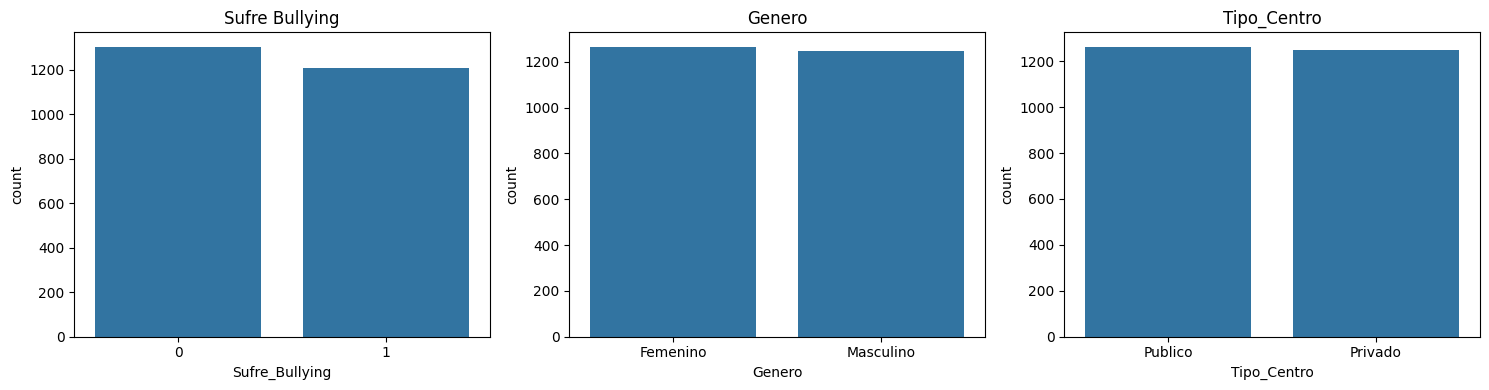

,count,mean,std,min,25%,50%,75%,max
Edad,2387.0,14.488479,1.726772,12.0,13.0,14.00,16.0,17.000000
Horas_Sueno,2512.0,6.980374,1.730333,4.0,5.5,7.00,8.5,10.000000
Notas_Promedio,2512.0,5.038694,2.908724,0.0,2.5,5.05,7.7,10.000000
Numero_Amigos,2387.0,6.836196,4.296481,0.0,3.0,7.00,11.0,14.000000
Tiempo_Videojuegos,2512.0,2.942675,1.710062,0.0,1.5,2.90,4.4,6.000000
Tiempo_Redes,2512.0,5.013416,2.876261,0.0,2.5,5.00,7.5,10.000000
Actividades_Extracurr,2512.0,2.006369,1.413354,0.0,1.0,2.00,3.0,4.000000
Ausencias_Escolares,2512.0,14.490048,8.592036,0.0,7.0,15.00,22.0,29.000000
Autoestima,2512.0,6.367421,6.820591,0.0,2.6,5.10,7.8,33.557282
Ansiedad,2512.0,6.743500,6.833098,0.0,3.0,5.80,8.2,33.977376


In [7]:
# ==============================================
# Analisis de los datos actualizados
# ==============================================

datos = X.copy()
datosY = (y.copy()).to_frame()
datosY
fig, ax = plt.subplots(1, 3, figsize=(15,4))

sns.countplot(data=datosY, x='Sufre_Bullying', ax=ax[0])
ax[0].set_title('Sufre Bullying')

sns.countplot(data=datos, x='Genero', ax=ax[1])
ax[1].set_title('Genero')

sns.countplot(data=datos, x='Tipo_Centro', ax=ax[2])
ax[2].set_title('Tipo_Centro')
plt.tight_layout(); plt.show()

num_cols = [c for c in datos.columns if datos[c].dtype != 'object']
pd.concat([datos[num_cols].describe().T, datosY.describe().T])

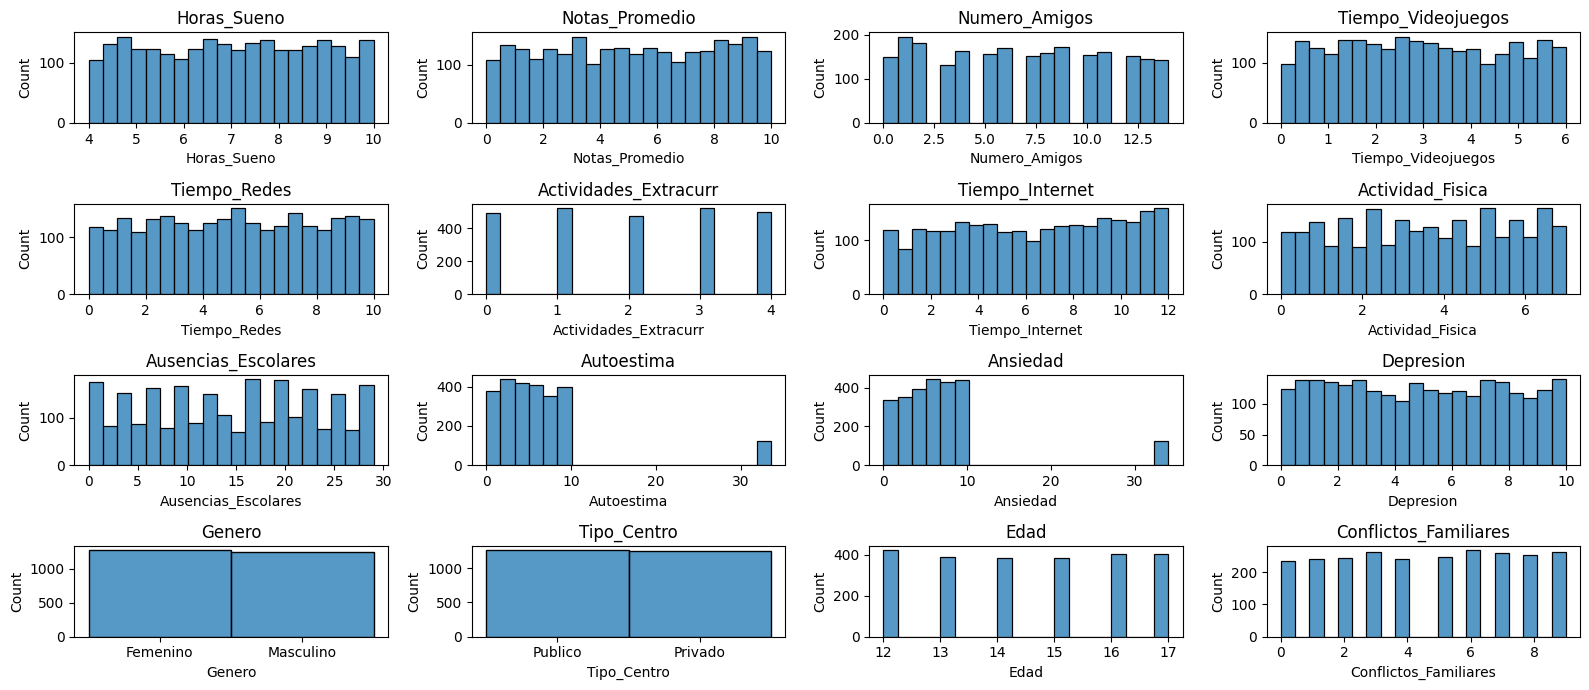

In [8]:
# ==============================================
# Analisis de los datos actualizados resto de variables
# ==============================================
num_sample = [
    'Horas_Sueno','Notas_Promedio','Numero_Amigos','Tiempo_Videojuegos',
    'Tiempo_Redes', 'Actividades_Extracurr', 'Tiempo_Internet','Actividad_Fisica','Ausencias_Escolares',
    'Autoestima','Ansiedad','Depresion', 'Genero', 'Tipo_Centro', 'Edad', 'Conflictos_Familiares'
]
num_sample = [c for c in num_sample if c in datos.columns]

fig, axes = plt.subplots(4, 4, figsize=(16,7))
axes = axes.ravel()
for i, c in enumerate(num_sample):
    sns.histplot(df[c], bins=20, ax=axes[i])
    axes[i].set_title(c)
plt.tight_layout(); plt.show()

<Axes: >

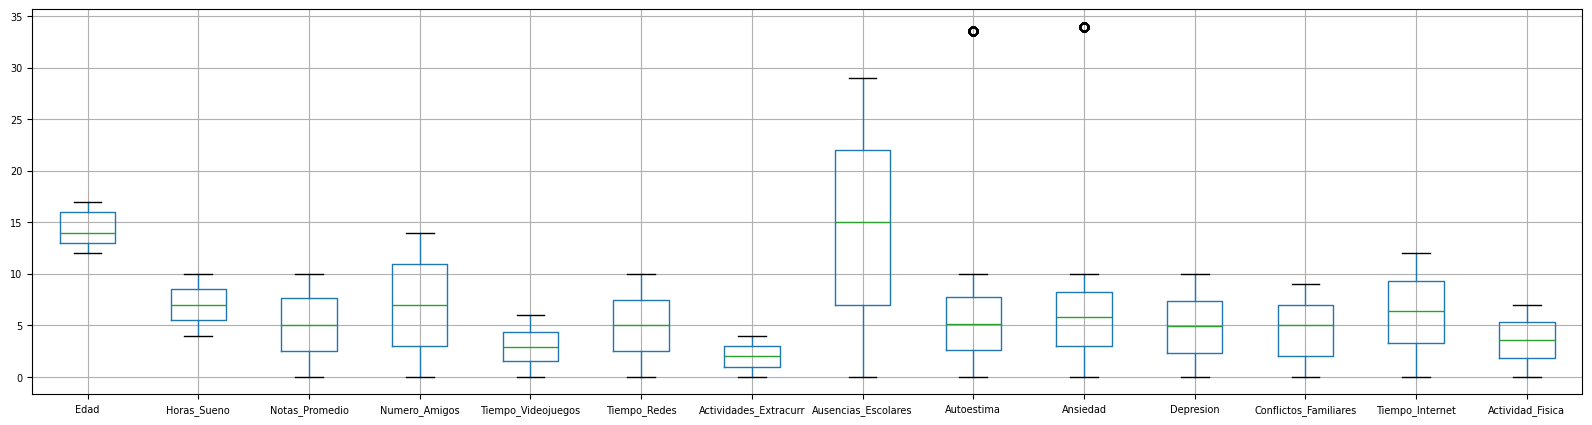

In [9]:
X.boxplot(fontsize=7,figsize=[20,5])

In [10]:
# ==============================================
# División en entrenamiento y test (80/20)
# ==============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=Semilla)

In [11]:
# ==============================================
# Preprocesamiento
# ==============================================
# Imputamos valores faltantes y escalamos variables numéricas
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Codificamos variables categóricas con OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Combinamos ambos preprocesamientos
preprocess = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
])

# Configura validación cruzada estratificada con 5 pliegues y barajado
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=Semilla)

In [12]:
# ==============================================
# Modelos empleados
# ==============================================

# A) Modelo base interpretable: Regresión Logística
logreg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

# B) Modelo de conjunto (Ensemble): Random Forest
rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=Semilla,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

# C) Modelo de conjunto (Ensemble): Gradient Boosting
gb = Pipeline([
    ("preprocess", preprocess),
    ("clf", GradientBoostingClassifier(random_state=Semilla))
])


In [13]:
# ==============================================
# Entrenamiento y evaluación
# ==============================================
    
modelos = {
    "Logistic Regression (balanced)": logreg,
    "Random Forest (balanced)": rf,
    "Gradient Boosting": gb
}

resultados = []

for nombre, modelo in modelos.items():
    print(f"\nEntrenando modelo: {nombre}")
    modelo.fit(X_train, y_train)

    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:, 1]

    report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, y_prob)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc)
    print("Matriz de confusión:\n", conf_matrix)

    resultados.append({
        "Modelo": nombre,
        "ROC_AUC": roc_auc,
        "Classification_Report": report,
        "Confusion_Matrix": conf_matrix.tolist(),
    })


Entrenando modelo: Logistic Regression (balanced)
              precision    recall  f1-score   support

           0       0.67      0.63      0.65       261
           1       0.62      0.66      0.64       242

    accuracy                           0.64       503
   macro avg       0.64      0.64      0.64       503
weighted avg       0.65      0.64      0.64       503

ROC-AUC: 0.6890693771571516
Matriz de confusión:
 [[164  97]
 [ 82 160]]

Entrenando modelo: Random Forest (balanced)
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       261
           1       0.82      0.91      0.86       242

    accuracy                           0.86       503
   macro avg       0.87      0.86      0.86       503
weighted avg       0.87      0.86      0.86       503

ROC-AUC: 0.913072733605649
Matriz de confusión:
 [[214  47]
 [ 22 220]]

Entrenando modelo: Gradient Boosting
              precision    recall  f1-score   support

           0

# **Análisis del dataset tras aplicar las técnicas**

Al contrario que en el primer conjunto de datos, ahora los datos si se encuentran balanceados por lo que no es necesario aplicar SMOTE para equilibrar los datos.

De igual forma que con el primer dataset, los  modelos más complejos, como Random Forest o Gradient Boostin, funcionan mejor que los modelos lineales, lo que confirma que en el dataset hay relaciones no tan simples entre las variables.

# **Evaluación y Comparación de Modelos de Clasificación**
### Regresión Logística
Precisión y recall: Ambos rondan el 0.64, lo que indica un rendimiento moderado.
Accuracy: 64%, bastante bajo comparado con los otros modelos.
ROC-AUC: 0.689, lo que muestra una capacidad discriminativa limitada.
Conclusión: Es un modelo simple que no captura bien la complejidad de los datos. Puede ser útil como baseline, pero no para producción.

### Random Forest:
Precisión y recall: Muy altos (≈0.86), balanceados entre clases.
Accuracy: 86%, una mejora significativa frente a Logistic Regression.
ROC-AUC: 0.913, excelente capacidad para distinguir entre clases.
Conclusión: Modelo robusto, buen equilibrio entre precisión y recall. Ideal para escenarios donde interpretabilidad no es crítica.

### Gradient Boosting:
Precisión y recall: Similar a Random Forest, ligeramente mejor en recall para clase positiva.
Accuracy: 88%, el mejor de los tres.
ROC-AUC: 0.917, el más alto, lo que indica gran discriminación.
Conclusión: Es el modelo más preciso y con mejor rendimiento global. Puede ser preferido para maximizar métricas, aunque es más complejo y costoso computacionalmente.

### Análisis de la matriz de confusión
Logistic Regression: Alta tasa de falsos negativos (82) y falsos positivos (97), Random Forest y Gradient Boosting: Reducen drásticamente los errores (FN y FP), lo que mejora la confiabilidad del modelo.

In [14]:
# ==============================================
# Rejillas de hiperparámetros para los tres modelos, configura búsquedas con validación cruzada mediante GridSearchCV,
# entrena esas búsquedas sobre el conjunto de entrenamiento y finalmente muestra el mejor ROC‑AUC (media CV) encontrado para cada modelo.
# ==============================================

#clf__penalty: tipo de regularización, que ayuda a controlar sobreajuste y multicolinealidad.
# clf__C: inversa de la fuerza de regularización (menor C ⇒ más regularización). Exploras tres niveles: 0.1 (más fuerte), 1.0 (base) y 3.0 (más laxa).
# clf__class_weight: pondera las clases.
# None: sin ponderación.
# balanced: peso inverso a la frecuencia, útil con desbalanceo.
param_logreg = {
    'clf__penalty': ['l2'],
    'clf__C': [0.1, 1.0, 3.0],
    'clf__class_weight': [None, 'balanced']
}
# clf__n_estimators: nº de árboles. Más árboles suele ↓varianza (hasta cierto punto) pero ↑tiempo.
# clf__max_depth: profundidad máxima de cada árbol.
# None: sin límite (potente pero puede sobreajustar).
# 10, 20: acotan complejidad.
# clf__min_samples_split: mínimo de muestras para dividir un nodo. Valores más altos ⇒ árboles más conservadores (↓sobreajuste).
# clf__min_samples_leaf: mínimo de muestras en una hoja. Subirlo también regulariza.
# clf__max_features: nº de features candidatas por división.
# sqrt: (habitual en clasificación), 'log2' (más restrictivo).
param_rf = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['sqrt', 'log2']
}
#clf__n_estimators: nº de árboles (iteraciones de boosting).
#clf__learning_rate: tasa de aprendizaje. Más baja suele requerir más árboles, pero mejora generalización.
#clf__max_depth: profundidad de cada árbol base (estimator débil). 2–3 es típico para Gradient Boosting.
param_gb = {
    'clf__n_estimators': [150, 250],
    'clf__learning_rate': [0.05, 0.1],
    'clf__max_depth': [2, 3]
}

# estimator: el Pipeline
# param_grid: param_logreg definido arriba.
# cv=cv: estrategia de validación "StratifiedKFold(n_splits=5, shuffle=True, random_state=Semilla)". Asegura estratificación y reproducibilidad con Semilla.
# scoring=['roc_auc','accuracy','f1']: calcula tres métricas en cada fold.
# refit='roc_auc': tras CV, rehace el ajuste con toda la partición de entrenamiento usando la mejor combinación según ROC‑AUC (tu métrica primaria). Deja el mejor pipeline listo en logreg_grid.best_estimator_.
# n_jobs=-1: usa todos los cores disponibles para acelerar.
# verbose=0: sin trazas en consola.
logreg_grid = GridSearchCV(
    modelos["Logistic Regression (balanced)"],
    param_logreg, 
    cv=cv,
    scoring=['roc_auc','accuracy','f1'], 
    refit='roc_auc', 
    n_jobs=-1, 
    verbose=0
)

rf_grid = GridSearchCV(
    modelos["Random Forest (balanced)"],
    param_rf,
    scoring=['roc_auc','accuracy','f1'],
    refit='roc_auc', 
    cv=cv,
    n_jobs=-1,
    verbose=0
)

gb_grid = GridSearchCV(
    modelos["Gradient Boosting"], 
    param_gb,
    scoring=['roc_auc','accuracy','f1'],
    cv=cv,    
    refit='roc_auc',
    n_jobs=-1,
    verbose=0
)
# Entrenamiento de las búsquedas (CV + refit)
logreg_grid.fit(X_train, y_train)

gb_grid.fit(X_train, y_train)

rf_grid.fit(X_train, y_train)

print('Mejor ROC-AUC (CV) — Logistic Regression (Bullying2):', round(logreg_grid.best_score_, 4))
print('Mejor ROC-AUC (CV) — Random Forest (Bullying2):', round(rf_grid.best_score_, 4))
print('Mejor ROC-AUC (CV) — Gradient Boosting (Bullying2):', round(gb_grid.best_score_, 4))

Mejor ROC-AUC (CV) — Logistic Regression (Bullying2): 0.7007
Mejor ROC-AUC (CV) — Random Forest (Bullying2): 0.9078
Mejor ROC-AUC (CV) — Gradient Boosting (Bullying2): 0.9098


=== Logistic Regression (balanced) ===
Mejores hiperparámetros: {'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2'}
Accuracy: 0.6441 F1: 0.6413 ROC-AUC: 0.6894
Matriz de confusión: [[164  97]
 [ 82 160]]
=== Random Forest (balanced) ===
Mejores hiperparámetros: {'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Accuracy: 0.8549 F1: 0.856 ROC-AUC: 0.9095
Matriz de confusión: [[213  48]
 [ 25 217]]
=== Gradient Boosting ===
Mejores hiperparámetros: {'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 150}
Accuracy: 0.8728 F1: 0.8725 ROC-AUC: 0.9171
Matriz de confusión: [[220  41]
 [ 23 219]]


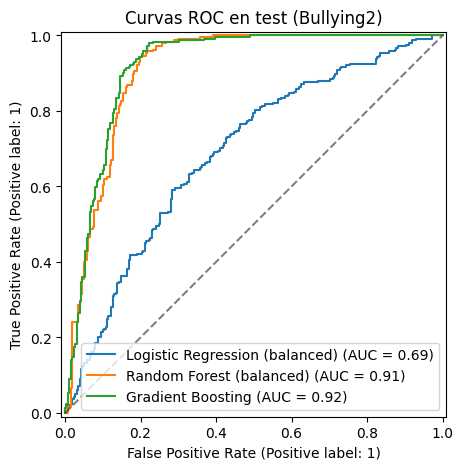

In [15]:
resultados_b2 = []
modelos = {
    "Logistic Regression (balanced)": logreg_grid,
    "Random Forest (balanced)": rf_grid,
    "Gradient Boosting": gb_grid
}

thresholds = np.arange(0.1, 0.9, 0.05)

resultados2 = []
# tras encontrar los mejores hipeparametros se hace reentrenamiento
for nombre, modelo in modelos.items():
    # extrae el mejor Pipeline encontrado por la búsqueda (refit='roc_auc').
    best = modelo.best_estimator_
    # calcula las probabilidades de la clase positiva (índice 1) para cada muestra de test.
    y_proba = best.predict_proba(X_test)[:,1]
    # convierte la probabilidad en predicción binaria usando umbral 0.5.
    y_pred = (y_proba >= 0.5).astype(int)

    #  proporción de aciertos globales
    acc = accuracy_score(y_test, y_pred)
    # media armónica precision–recall para la clase positiva
    f1 = f1_score(y_test, y_pred)
    # área bajo la curva ROC usando probabilidades
    auc = roc_auc_score(y_test, y_proba)
    # matriz 2×2 con TN, FP, FN, TP al umbral 0.5
    cm = confusion_matrix(y_test, y_pred)

    resultados_b2.append({'modelo': nombre, 'accuracy': acc, 'f1': f1, 'roc_auc': auc, 'y_proba': y_proba,
                       'best_params': modelo.best_params_, 'best': best})

    print('=== ' + nombre + ' ===')
    print('Mejores hiperparámetros:', modelo.best_params_)
    print('Accuracy:', round(acc,4), 'F1:', round(f1,4), 'ROC-AUC:', round(auc,4))
    print('Matriz de confusión:', cm)

resultados2 = pd.DataFrame(resultados_b2).sort_values('roc_auc', ascending=False)

#Comparativa gráfica: Curvas ROC en test
fig, ax = plt.subplots(figsize=(7,5))
for nombre, modelo in modelos.items():
    RocCurveDisplay.from_estimator(modelo.best_estimator_, X_test, y_test, ax=ax, name=nombre)
ax.plot([0,1],[0,1],'k--', alpha=0.5)
ax.set_title('Curvas ROC en test (Bullying2)')
plt.show()

Por defecto, los modelos de clasificación binaria usan un umbral de 0.5 para determinar si un caso pertenece a la clase positiva. Sin embargo, este valor no siempre maximiza el equilibrio entre aciertos y errores.

Se realizó un análisis del F1-score para distintos umbrales de probabilidad, con el fin de identificar el punto que ofreciera el mejor balance entre precisión y recall.

En la práctica, esto indica que el modelo obtiene un mejor equilibrio entre identificar correctamente los casos relevantes (recall) y mantener una buena tasa de aciertos (precisión), resultando en un rendimiento más estable y útil para la aplicación final.

In [16]:
# Rango de umbrales de decisión
thresholds = np.arange(0.1, 0.9, 0.05)
for index, row in resultados2.iterrows():
    row['f1_scores'] = [f1_score(y_test, row['y_proba'] > t) for t in thresholds]
    row['best_t'] = thresholds[np.argmax(row['f1_scores'])]
    print(f"Umbral óptimo para F1 en {row['modelo']}: {row['best_t']:.2f}")

Umbral óptimo para F1 en Gradient Boosting: 0.30
Umbral óptimo para F1 en Random Forest (balanced): 0.45
Umbral óptimo para F1 en Logistic Regression (balanced): 0.40


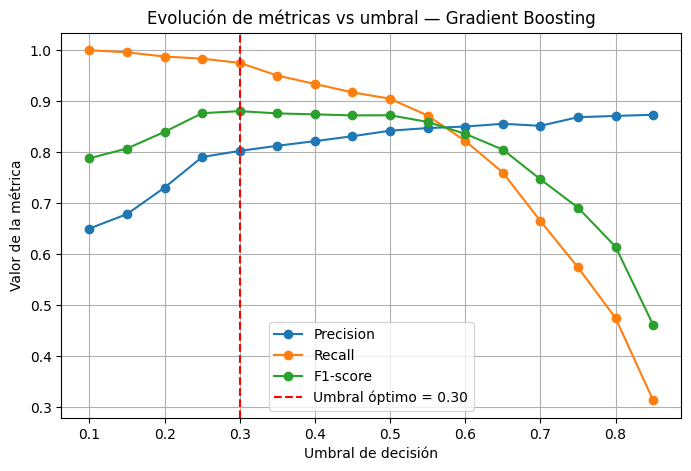

[Gradient Boosting] Umbral óptimo (F1): 0.30  F1=0.881


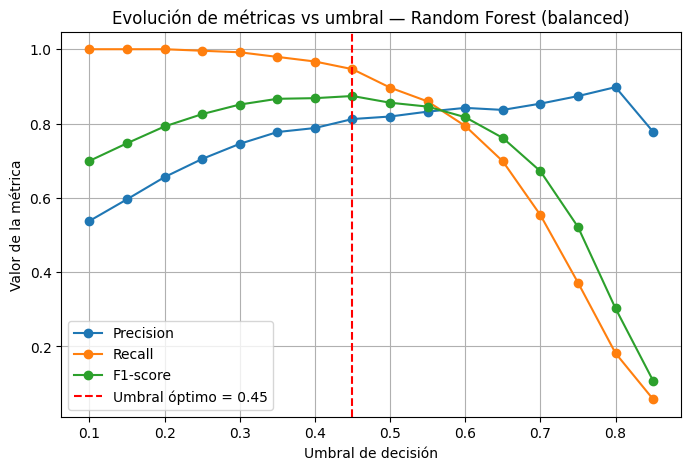

[Random Forest (balanced)] Umbral óptimo (F1): 0.45  F1=0.874


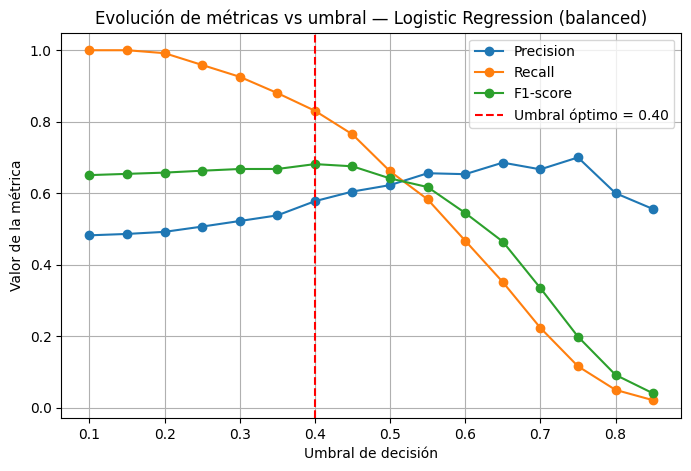

[Logistic Regression (balanced)] Umbral óptimo (F1): 0.40  F1=0.681


In [17]:
# Asegura columnas para guardar resultados agregados

for idx, row in resultados2.iterrows():
    nombre = row['modelo']
    y_proba = row['y_proba']  # vector guardado en el DF
    precisions, recalls, f1s = [], [], []

    for t in thresholds:
        y_pred = (y_proba > t).astype(int)
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))

    best_idx = int(np.argmax(f1s))
    best_t = float(thresholds[best_idx])
    best_f1 = float(f1s[best_idx])

    # Guarda en el DataFrame (NO en row; iterrows devuelve copia)
    resultados2.loc[idx, 'best_threshold'] = best_t
    resultados2.loc[idx, 'best_f1'] = best_f1

    # Gráfico por modelo
    plt.figure(figsize=(8,5))
    plt.plot(thresholds, precisions, label='Precision', marker='o')
    plt.plot(thresholds, recalls,   label='Recall',    marker='o')
    plt.plot(thresholds, f1s,       label='F1-score',  marker='o')
    plt.axvline(best_t, color='red', linestyle='--', label=f'Umbral óptimo = {best_t:.2f}')
    plt.title(f'Evolución de métricas vs umbral — {nombre}')
    plt.xlabel('Umbral de decisión'); plt.ylabel('Valor de la métrica')
    plt.legend(); plt.grid(True); plt.show()

    print(f"[{nombre}] Umbral óptimo (F1): {best_t:.2f}  F1={best_f1:.3f}")

Interpretación de la evolución de las métricas según el umbral de decisión

La gráfica muestra cómo cambian las tres métricas principales del modelo —precisión, recall y F1-score— a medida que se ajusta el umbral de decisión (es decir, el punto a partir del cual el modelo clasifica una observación como positiva).

* **La línea azul (precisión)** representa el porcentaje de
predicciones positivas que fueron correctas.
Se observa que la precisión aumenta al subir el umbral, porque el modelo se vuelve más exigente para clasificar como positivo, reduciendo falsos positivos.

*  **La línea naranja (recall)** muestra la capacidad del modelo para detectar todos los casos positivos reales.
Al contrario que la precisión, el recall disminuye al aumentar el umbral, ya que el modelo deja de identificar algunos casos positivos (aumentan los falsos negativos).

* **La línea verde (F1-score)** combina precisión y recall en una sola métrica, buscando el mejor equilibrio entre ambas.

Este punto representa el umbral óptimo: el modelo logra el mejor balance entre detectar correctamente los casos positivos y mantener una buena precisión en sus predicciones.

Esto es especialmente útil en problemas donde es más importante detectar todos los casos relevantes (por ejemplo, fraudes, enfermedades, alertas, etc.) que evitar algunos falsos positivos.

## Feature importance con Gradient Boosting ##

Ya que en el proyecto el modelo que mejor funcionó fue Gradient Boosting, este modelo nos da directamente las variables más influyentes.

In [18]:
# 1. Obtener importancias desde el Gradient Boost del pipeline
importances = resultados2.loc[2, 'best'].named_steps['clf'].feature_importances_

# 2. Obtener nombres de las features transformadas por el ColumnTransformer
feature_names = (
    resultados2.loc[2, 'best'].named_steps['preprocess']
          .get_feature_names_out()
)

# 3. Crear DataFrame ordenado
importance_df = pd.DataFrame({
    'variable': feature_names,
    'importancia': importances
}).sort_values('importancia', ascending=False)

importance_df.head(20)

,variable,importancia
9,num__Ansiedad,0.251864
12,num__Tiempo_Internet,0.228598
8,num__Autoestima,0.139520
2,num__Notas_Promedio,0.090408
5,num__Tiempo_Redes,0.089935
3,num__Numero_Amigos,0.070688
11,num__Conflictos_Familiares,0.058981
1,num__Horas_Sueno,0.032582
10,num__Depresion,0.021128
13,num__Actividad_Fisica,0.006571


El análisis de importancia de variables, realizado mediante un modelo Gradient Boosting, revela que los factores más determinantes en la probabilidad de sufrir bullying son de naturaleza emocional y relacional. Las variables con mayor influencia fueron Ansiedad (0.248), Tiempo dedicado a Internet (0.191) y Autoestima (0.143). Estas dimensiones indican que los estudiantes con mayor vulnerabilidad emocional o con elevada exposición digital presentan un riesgo significativamente mayor de ser víctimas de acoso escolar.

Otras variables relevantes incluyen el rendimiento académico, el número de amigos, las horas de sueño y la presencia de conflictos familiares, lo que sugiere que el entorno personal y social del estudiante juega un papel fundamental en la aparición del bullying.

En contraste, variables como el género, la edad o el tipo de centro educativo muestran una influencia mínima en la predicción, lo que indica que, en este dataset, el acoso escolar no depende de características demográficas, sino de factores emocionales, sociales y de hábitos de vida.

En conjunto, estos resultados subrayan la importancia de abordar el bullying desde una perspectiva integral, que incluya la salud mental del alumnado, la calidad de sus relaciones sociales y la influencia del entorno familiar y digital.

Accedemos al modelo Gradient Boosting dentro del pipeline y obtenemos las importancias de cada variable, es decir, cuánto contribuye cada característica a predecir la variable objetivo “sufre_bullying”:

In [19]:
resultados2.loc[2, 'best'].named_steps["clf"].feature_importances_

array([9.51614116e-04, 3.25821543e-02, 9.04081260e-02, 7.06884006e-02,
       5.74049635e-03, 8.99349709e-02, 8.32854242e-05, 2.94876156e-03,
       1.39519727e-01, 2.51864485e-01, 2.11283725e-02, 5.89808768e-02,
       2.28597546e-01, 6.57118360e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

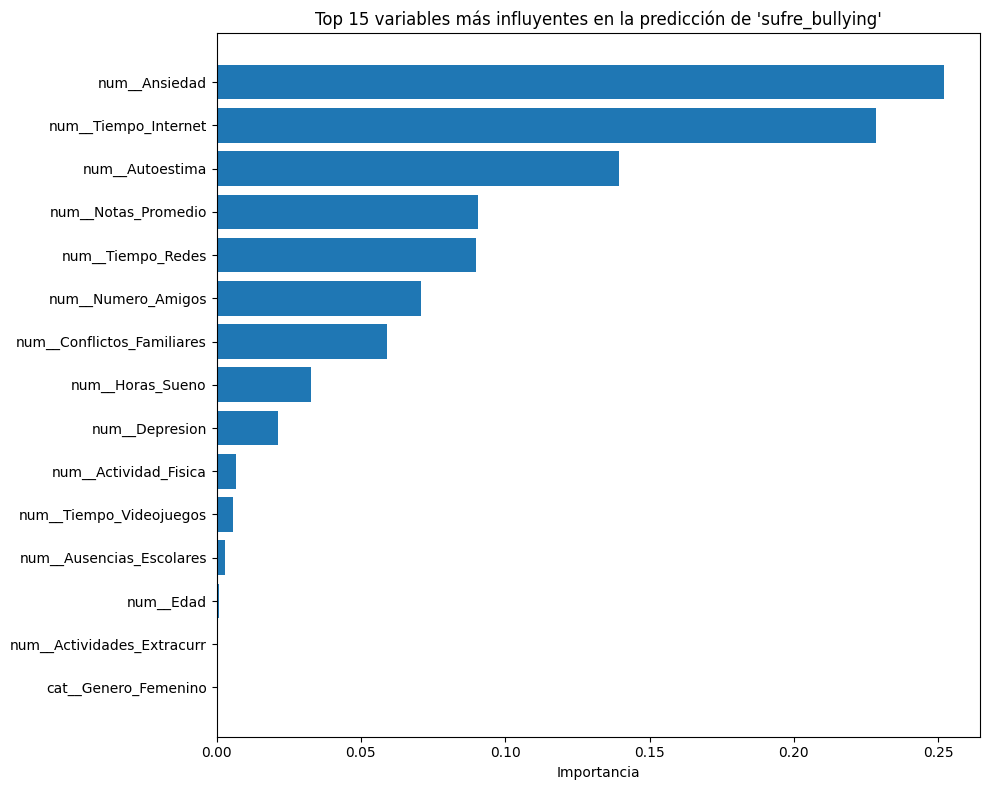

In [20]:
# Extraer importancias del RandomForest dentro del Pipeline
importances = resultados2.loc[2, 'best'].named_steps['clf'].feature_importances_

# Obtener los nombres de las variables después del preprocesamiento
# ColumnTransformer expande las variables categóricas
feature_names = resultados2.loc[2, 'best'].named_steps['preprocess'].get_feature_names_out()

# Crear dataframe ordenado
importance_df = pd.DataFrame({
    'variable': feature_names,
    'importancia': importances
}).sort_values('importancia', ascending=False)

# --- Plot ---
plt.figure(figsize=(10, 8))
plt.barh(importance_df['variable'][:15][::-1], 
         importance_df['importancia'][:15][::-1])
plt.xlabel("Importancia")
plt.title("Top 15 variables más influyentes en la predicción de 'sufre_bullying'")
plt.tight_layout()
plt.show()

La gráfica muestra las 15 variables más influyentes en la predicción de la variable objetivo “sufre_bullying” según el modelo Gradient Boosting. Cada barra representa la importancia relativa de una característica dentro del modelo: cuanto mayor es la barra, mayor es el peso de esa variable para distinguir entre alumnado que sufre acoso y alumnado que no.

##### 1. Variables emocionales y psicológicas (las más influyentes) #####

Las variables con mayor importancia son Ansiedad, Tiempo en Internet y Autoestima, lo que indica que el malestar emocional y el uso intensivo de dispositivos digitales son factores estrechamente relacionados con el riesgo de sufrir acoso escolar.

Ansiedad aparece como el predictor más determinante.

Autoestima baja también destaca como un factor clave.

Esto coincide con la literatura científica: los estudiantes con mayor vulnerabilidad emocional o inseguridad suelen estar más expuestos a situaciones de victimización.

##### 2. Hábitos digitales y estilo de vida

Variables como Tiempo en Internet, Tiempo en Redes Sociales y Horas de Sueño también tienen un peso importante.

El uso intensivo de redes sociales puede aumentar la exposición a conflictos o ciberacoso.

Dormir poco se asocia con estrés, problemas emocionales y una mayor sensibilidad social.

##### 3. Aspectos académicos y escolares

Notas Promedio y Ausencias Escolares también aparecen entre las variables relevantes.
Un rendimiento más bajo o ausencias frecuentes pueden reflejar problemas previos o consecuencias del acoso.

Número de Amigos influye positivamente: menos relaciones sociales aumenta el riesgo.

##### 4. Entorno familiar y social

La presencia de Conflictos Familiares es otro factor influyente.
Los estudiantes que viven en ambientes familiares tensos o conflictivos tienen mayor probabilidad de experimentar dificultades relacionales en la escuela.

##### 5. Actividad física y otras variables de estilo de vida

La Actividad Física y el Tiempo en Videojuegos también contribuyen, aunque con menor peso relativo.
Suelen estar asociados al nivel de socialización, manejo del estrés y hábitos de ocio.

#####  6. Variables demográficas

Por último, variables como Género o Edad tienen poca influencia en comparación con las variables emocionales y sociales, lo que sugiere que en este dataset el riesgo de bullying está más ligado al contexto emocional, familiar y social que a factores demográficos.

## Comparativa - Repetición del pipeline sobre **Bullying1** para comparar resultados


Entrenando modelo: Logistic Regression (balanced)
              precision    recall  f1-score   support

           0       0.74      0.66      0.70       259
           1       0.48      0.57      0.52       141

    accuracy                           0.63       400
   macro avg       0.61      0.62      0.61       400
weighted avg       0.65      0.63      0.64       400

ROC-AUC: 0.669952627399436
Matriz de confusión:
 [[172  87]
 [ 61  80]]

Entrenando modelo: Random Forest (balanced)
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       259
           1       0.78      0.69      0.73       141

    accuracy                           0.82       400
   macro avg       0.81      0.79      0.80       400
weighted avg       0.82      0.82      0.82       400

ROC-AUC: 0.9128946575755087
Matriz de confusión:
 [[232  27]
 [ 44  97]]

Entrenando modelo: Gradient Boosting
              precision    recall  f1-score   support

           0

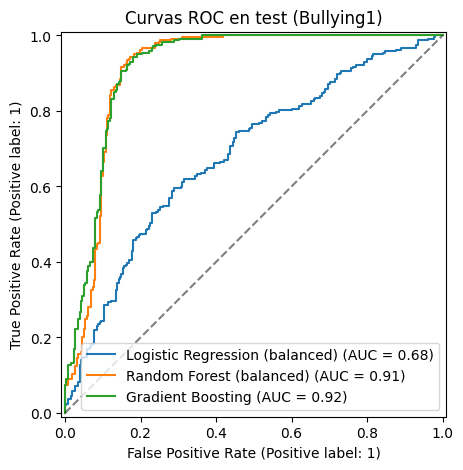

In [21]:
# ==============================================
# División en entrenamiento y test (80/20)
# ==============================================
XOld_train, XOld_test, yOld_train, yOld_test = train_test_split(
    XOld, yOld, test_size=0.2, stratify=yOld, random_state=Semilla)
	
	
# ==============================================
# Entrenamiento y evaluación
# ==============================================
    
modelos = {
    "Logistic Regression (balanced)": logreg,
    "Random Forest (balanced)": rf,
    "Gradient Boosting": gb
}

resultados = []

for nombre, modelo in modelos.items():
    print(f"\nEntrenando modelo: {nombre}")
    modelo.fit(XOld_train, yOld_train)

    y_pred = modelo.predict(XOld_test)
    y_prob = modelo.predict_proba(XOld_test)[:, 1]

    report = classification_report(yOld_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(yOld_test, y_prob)
    conf_matrix = confusion_matrix(yOld_test, y_pred)

    print(classification_report(yOld_test, y_pred))
    print("ROC-AUC:", roc_auc)
    print("Matriz de confusión:\n", conf_matrix)

    resultados.append({
        "Modelo": nombre,
        "ROC_AUC": roc_auc,
        "Classification_Report": report,
        "Confusion_Matrix": conf_matrix.tolist(),
    })
	
logreg_grid.fit(XOld_train, yOld_train)

gb_grid.fit(XOld_train, yOld_train)

rf_grid.fit(XOld_train, yOld_train)

print('Mejor ROC-AUC (CV) — Logistic Regression (Bullying2):', round(logreg_grid.best_score_, 4))
print('Mejor ROC-AUC (CV) — Random Forest (Bullying2):', round(rf_grid.best_score_, 4))
print('Mejor ROC-AUC (CV) — Gradient Boosting (Bullying2):', round(gb_grid.best_score_, 4))

resultados_b1 = []
modelos = {
    "Logistic Regression (balanced)": logreg_grid,
    "Random Forest (balanced)": rf_grid,
    "Gradient Boosting": gb_grid
}

resultados1 = []
# tras encontrar los mejores hipeparametros se hace reentrenamiento
for nombre, modelo in modelos.items():
    # extrae el mejor Pipeline encontrado por la búsqueda (refit='roc_auc').
    best = modelo.best_estimator_
    # calcula las probabilidades de la clase positiva (índice 1) para cada muestra de test.
    y_proba = best.predict_proba(XOld_test)[:,1]
    # convierte la probabilidad en predicción binaria usando umbral 0.5.
    y_pred = (y_proba >= 0.5).astype(int)

    #  proporción de aciertos globales
    acc = accuracy_score(yOld_test, y_pred)
    # media armónica precision–recall para la clase positiva
    f1 = f1_score(yOld_test, y_pred)
    # área bajo la curva ROC usando probabilidades
    auc = roc_auc_score(yOld_test, y_proba)
    # matriz 2×2 con TN, FP, FN, TP al umbral 0.5
    cm = confusion_matrix(yOld_test, y_pred)

    resultados_b1.append({'modelo': nombre, 'accuracy': acc, 'f1': f1, 'roc_auc': auc, 'y_proba': y_proba,
                       'best_params': modelo.best_params_})

    print('=== ' + nombre + ' ===')
    print('Mejores hiperparámetros:', modelo.best_params_)
    print('Accuracy:', round(acc,4), 'F1:', round(f1,4), 'ROC-AUC:', round(auc,4))
    print('Matriz de confusión:', cm)

resultados1 = pd.DataFrame(resultados_b1).sort_values('roc_auc', ascending=False)
resultados1

#Comparativa gráfica: Curvas ROC en test
fig, ax = plt.subplots(figsize=(7,5))
for nombre, modelo in modelos.items():
    RocCurveDisplay.from_estimator(modelo.best_estimator_, X_test, y_test, ax=ax, name=nombre)
ax.plot([0,1],[0,1],'k--', alpha=0.5)
ax.set_title('Curvas ROC en test (Bullying1)')
plt.show()

In [22]:
# Unimos resultados por nombre de modelo
comparativa = resultados1.merge(resultados2, on='modelo', suffixes=('_B1','_B2'))[
    ['modelo', 'accuracy_B1','f1_B1','roc_auc_B1','accuracy_B2','f1_B2','roc_auc_B2']
]

# También mostramos el top model de cada parte
print('Top (B1):', resultados1.iloc[0]['modelo'], '| ROC-AUC:', round(float(resultados1.iloc[0]['roc_auc']),4))
print('Top (B2):', resultados2.iloc[0]['modelo'], '| ROC-AUC:', round(float(resultados2.iloc[0]['roc_auc']),4))

comparativa

Top (B1): Random Forest (balanced) | ROC-AUC: 0.9124
Top (B2): Gradient Boosting | ROC-AUC: 0.9171


,modelo,accuracy_B1,f1_B1,roc_auc_B1,accuracy_B2,f1_B2,roc_auc_B2
0,Random Forest (balanced),0.8475,0.782918,0.912374,0.854871,0.856016,0.909455
1,Gradient Boosting,0.8350,0.760870,0.901640,0.872763,0.872510,0.917086
2,Logistic Regression (balanced),0.6325,0.524272,0.669788,0.644135,0.641283,0.689386


# Resultados de la comparación

Observamos que con los nuevos datos, el mejor resultado lo obtenemos con Gradient Boosting, por otro lado al tener los datos balanceados nos ahorramos el tener que aplicar metodos de balanceo como SMOTE.